## Feature Engineering Deep Dive チュートリアル

- [1. データの読み込みと確認](#readData)
    - データのロードと内容確認
    - 型変換
- [2. ベースラインモデルの作成](#baseline)
    - AutoML
    - モデルパフォーマンスと変数重要度の確認
- [3. Feature Engineeringとそれを利用したモデルの作成](#FE)
    - Feature Engineeringの実施
    - XXX

In [1]:
import h2o
import matplotlib as plt
%matplotlib inline
from h2o.automl import H2OAutoML

In [2]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd4ye2e_3
  JVM stdout: /tmp/tmpd4ye2e_3/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmpd4ye2e_3/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_ec2_user_c79csg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.399 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


***

<a id='readData'></a>
### 1. データの読み込みと確認

In [3]:
#> データのロード
loans = h2o.import_file("https://sample-data-open.s3-ap-northeast-1.amazonaws.com/h2o_sample_loan/loan.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
loans.head(5)

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
5000,36 months,10.65,10,RENT,24000,credit_card,AZ,27.65,0,83.7,9,0,26,verified
2500,60 months,15.27,0,RENT,30000,car,GA,1,0,9.4,4,1,12,verified
2400,36 months,15.96,10,RENT,12252,small_business,IL,8.72,0,98.5,10,0,10,not verified
10000,36 months,13.49,10,RENT,49200,other,CA,20,0,21,37,0,15,verified
5000,36 months,7.9,3,RENT,36000,wedding,AZ,11.2,0,28.3,12,0,7,verified


In [5]:
loans.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,int,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,0.0,0.0,
mean,13074.169141456336,,13.715904065566168,5.684352932995333,,71915.67051974915,,,15.881530121290089,0.2273570060625282,54.07917280242262,24.57973383427463,0.1830388994249544,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,1.0,65.0,
sigma,7993.556188734652,,4.3919398705457935,3.610663731100237,,59070.91565491827,,,7.587668224192549,0.694167922928418,25.285366766770515,11.685190365910659,0.3866995896078875,6.947732922546697,
zeros,0,,0,14248,,0,,,270,139459,1562,0,133971,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0.0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1.0,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0.0,10.0,not verified


#### データに関して

[LendingClub](https://www.lendingclub.com/info/statistics.action)データに対しデータクレンジングと簡素化を実施したもの

|Id  | Column Name | Description | 説明 |
|:---|:----------------------|:-------------------|:-------------------|
|1   | loan_amnt             | Requested loan amount (US dollars)       | 申し込まれたローンの額(USD) |
|2   | term                  | Loan term length (months)       | 申し込まれたローン期間(月) |
|3   | int_rate              | Recommended interest rate       | 貸出金利 |
|4   | emp_length            | Employment length (years)       | 継続雇用期間(年) |
|5   | home_ownership        | Housing status       | 住居形態 |
|6   | annual_inc            | Annual income (US dollars)       | 年収(USD) |
|7   | purpose               | Purpose for the loan       | ローン借り入れ理由 |
|8   | addr_state            | State of residence       | 居住州 |
|9   | dti                   | Debt to income ratio       | 負債比率(%)（既存のローンの返済額を借り手の月収で割った率） |
|10  | delinq_2yrs           | Number of delinquencies in the past 2 years       | 過去2年における滞納回数 |
|11  | revol_util            | Percent of revolving credit line utilized       | リボルビングクレジット利用率(%) |
|12  | total_acc             | Number of active accounts       | 与信枠数 |
|13  | bad_loan              | Bad loan indicator       | 不良貸し付け |
|14  | longest_credit_length | Age of oldest active account       | 最長の与信枠(年) |
|15  | verification_status   | Income verification status       | 所得確認状況 |

参考：[Lending Club Loan Analysis](https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics) on Kaggle Notebook

`bad_loan`をターゲットとしてモデル作成

In [6]:
#> int型をカテゴリ型(enum)へ変更
loans['bad_loan'] = loans['bad_loan'].asfactor()

In [7]:
loans['bad_loan'].describe()

Rows:163987
Cols:1




,bad_loan
type,enum
mins,
mean,
maxs,
sigma,
zeros,
missing,0
0,0
1,1
2,0


In [8]:
#> 水準数の確認（1:不良貸し付け）
loans['bad_loan'].table()

bad_loan,Count
0,133971
1,30016


In [9]:
#> 1:不良貸し付けの割合
loans['bad_loan'].table()[1,1]/loans.nrows

0.1830388994249544

In [10]:
#> 学習/テストデータセットへの分割（学習:テスト = 80%:20% ）
train, test = loans.split_frame([0.8], seed=12345)
print(">> train/testのデータ数")
print("train:%d test:%d" % (train.nrows, test.nrows))

>> train/testのデータ数
train:131248 test:32739


***

<a id='baseline'></a>
### 2. ベースラインモデルの作成

In [11]:
response = "bad_loan"   # ターゲット変数

predictors = train.col_names
predictors.remove(response)
predictors.remove("int_rate")
predictors   # 特徴量(13)

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

In [12]:
aml = H2OAutoML(max_models = 6,
                max_runtime_secs_per_model = 60,
                exclude_algos = ['DRF', 'DeepLearning', 'StackedEnsemble'],
                seed = 12345)

%time aml.train(x = predictors, y = response, training_frame = train)

AutoML progress: |█████████
13:58:36.388: GLM_1_AutoML_20201014_135624 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 82

███████████████████████████████████████████████| 100%
CPU times: user 5.91 s, sys: 196 ms, total: 6.11 s
Wall time: 3min 46s


- max_models（作成する最大モデル数）かmax_runtime_secs（最大実行時間数）の設定に達すると、探索が終了（[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#required-stopping-parameters)）
- [exclude_algos](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html)にしたアルゴリズムはAutoMLで試行されない

In [13]:
#> k分割交差検証法の分割数(k)
aml.nfolds

5

In [14]:
#> k分割交差検証法による結果。AUC順
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201014_135624,0.681176,0.443732,0.319553,0.36962,0.373555,0.139544
XGBoost_3_AutoML_20201014_135624,0.679816,0.444138,0.318098,0.370936,0.373766,0.139701
GBM_2_AutoML_20201014_135624,0.679021,0.444618,0.315893,0.371141,0.374013,0.139886
GBM_3_AutoML_20201014_135624,0.676137,0.445671,0.313651,0.372875,0.374456,0.140217
XGBoost_1_AutoML_20201014_135624,0.661465,0.454788,0.298036,0.383594,0.378417,0.143199
XGBoost_2_AutoML_20201014_135624,0.645434,0.46848,0.282982,0.395931,0.383562,0.14712


並び順に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/sort_metric.html)

In [15]:
#> leaderboardの一番上のモデル
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201014_135624


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,52.0,52.0,47956.0,6.0,6.0,6.0,32.0,64.0,58.923077




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1330293974524767
RMSE: 0.3647319528811216
LogLoss: 0.4254314489578683
Mean Per-Class Error: 0.33645415118293
AUC: 0.7257812953735341
AUCPR: 0.40112712250300603
Gini: 0.45156259074706817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21000410129532213: 


,,0,1,Error,Rate
0,0,80870.0,26438.0,0.2464,(26438.0/107308.0)
1,1,10368.0,13572.0,0.4331,(10368.0/23940.0)
2,Total,91238.0,40010.0,0.2804,(36806.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.210004,0.424457,221.0
1,max f2,0.123976,0.569923,313.0
2,max f0point5,0.309659,0.414528,142.0
3,max accuracy,0.416478,0.825392,82.0
4,max precision,0.856613,1.000000,0.0
5,max recall,0.035840,1.000000,398.0
6,max specificity,0.856613,1.000000,0.0
7,max absolute_mcc,0.249072,0.271708,188.0
8,max min_per_class_accuracy,0.183263,0.661908,247.0
9,max mean_per_class_accuracy,0.185238,0.663546,245.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.509204,4.096121,4.096121,0.747144,0.572163,0.747144,0.572163,0.040977,0.040977,309.612149,309.612149,0.037884
1,2,0.020000,0.457852,3.317838,3.707128,0.605183,0.480447,0.676190,0.526322,0.033166,0.074144,231.783829,270.712814,0.066223
2,3,0.030004,0.427133,2.918643,3.444233,0.532369,0.441654,0.628238,0.498093,0.029198,0.103342,191.864314,244.423306,0.089699
3,4,0.040001,0.403387,2.703579,3.259140,0.493140,0.414617,0.594476,0.477232,0.027026,0.130368,170.357856,225.913998,0.110527
4,5,0.050005,0.383508,2.534501,3.114168,0.462300,0.393153,0.568033,0.460411,0.025355,0.155723,153.450127,211.416807,0.129303
5,6,0.100002,0.320561,2.162204,2.638222,0.394392,0.348773,0.481219,0.404596,0.108104,0.263826,116.220364,163.822212,0.200373
6,7,0.150006,0.280387,1.761744,2.346048,0.321347,0.299464,0.427926,0.369550,0.088095,0.351921,76.174369,134.604780,0.246962
7,8,0.200003,0.251424,1.547296,2.146375,0.282231,0.265316,0.391505,0.343494,0.077360,0.429282,54.729565,114.637498,0.280430
8,9,0.300005,0.211053,1.315769,1.869506,0.240000,0.229988,0.341003,0.305658,0.131579,0.560860,31.576942,86.950646,0.319052
9,10,0.399998,0.181878,1.056873,1.666360,0.192777,0.195737,0.303949,0.278180,0.105681,0.666541,5.687311,66.635973,0.326008




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13954355878848432
RMSE: 0.37355529548981675
LogLoss: 0.44373204240160347
Mean Per-Class Error: 0.36793432447933117
AUC: 0.6811763163001875
AUCPR: 0.3195529756610926
Gini: 0.362352632600375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19121624842192197: 


,,0,1,Error,Rate
0,0,72998.0,34310.0,0.3197,(34310.0/107308.0)
1,1,10043.0,13897.0,0.4195,(10043.0/23940.0)
2,Total,83041.0,48207.0,0.3379,(44353.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.191216,0.385241,235.0
1,max f2,0.113116,0.551538,321.0
2,max f0point5,0.275878,0.346527,160.0
3,max accuracy,0.536628,0.817971,33.0
4,max precision,0.834213,1.000000,0.0
5,max recall,0.034767,1.000000,397.0
6,max specificity,0.834213,1.000000,0.0
7,max absolute_mcc,0.198377,0.209207,228.0
8,max min_per_class_accuracy,0.178389,0.629616,247.0
9,max mean_per_class_accuracy,0.170065,0.632066,255.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.504740,2.755800,2.755800,0.502666,0.563913,0.502666,0.563913,0.027569,0.027569,175.580039,175.580039,0.021484
1,2,0.020000,0.454920,2.569862,2.662867,0.468750,0.477531,0.485714,0.520739,0.025689,0.053258,156.986216,166.286669,0.040678
2,3,0.030004,0.424099,2.309027,2.544890,0.421173,0.438426,0.464195,0.493294,0.023099,0.076358,130.902669,154.489007,0.056695
3,4,0.040001,0.400737,2.202142,2.459236,0.401677,0.412039,0.448571,0.472988,0.022013,0.098371,120.214204,145.923571,0.071393
4,5,0.050005,0.381668,2.125307,2.392430,0.387662,0.391174,0.436386,0.456620,0.021261,0.119632,112.530667,139.242955,0.085162
5,6,0.100002,0.319052,1.905713,2.149090,0.347607,0.347000,0.392000,0.401814,0.095280,0.214912,90.571349,114.909006,0.140547
6,7,0.150006,0.279424,1.622241,1.973465,0.295901,0.297968,0.359965,0.367197,0.081119,0.296032,62.224099,97.346478,0.178603
7,8,0.200003,0.251198,1.494661,1.853773,0.272630,0.264785,0.338133,0.341596,0.074728,0.370760,49.466086,85.377292,0.208852
8,9,0.300005,0.211133,1.294884,1.667477,0.236190,0.230058,0.304152,0.304417,0.129490,0.500251,29.488419,66.747668,0.244920
9,10,0.399998,0.181879,1.131648,1.533527,0.206416,0.195970,0.279720,0.277307,0.113158,0.613409,13.164793,53.352715,0.261021




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.64853543,0.01507191,0.6656,0.64849526,0.6501333,0.65408206,0.62436664
1,auc,0.6811718,0.002338276,0.67988724,0.67933655,0.68495834,0.67976797,0.6819087
2,aucpr,0.31993786,0.004454398,0.31562677,0.317051,0.32592648,0.32335785,0.31772715
3,err,0.35146454,0.01507191,0.3344,0.35150477,0.34986666,0.34591794,0.37563336
4,err_count,9225.8,395.5189,8778.0,9227.0,9184.0,9080.0,9860.0
5,f0point5,0.31744868,0.0031922602,0.31710637,0.31528866,0.32086727,0.32044545,0.31353563
6,f1,0.38643736,0.0039812895,0.38104638,0.38400427,0.39098144,0.3869835,0.3891711
7,f2,0.49398082,0.013385564,0.47728395,0.4910196,0.5003055,0.48839507,0.51290005
8,lift_top_group,2.768916,0.2272048,2.9044082,2.699827,2.9355848,2.905773,2.3989859
9,logloss,0.44373208,0.0026912112,0.44009697,0.44331858,0.44253618,0.44680297,0.44590575



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-14 13:59:04,27.934 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-14 13:59:04,28.413 sec,5.0,0.378506,0.456438,0.686677,0.341127,3.262721,0.318953
2,,2020-10-14 13:59:05,28.800 sec,10.0,0.374227,0.446749,0.694804,0.354703,3.557488,0.318534
3,,2020-10-14 13:59:05,29.162 sec,15.0,0.371776,0.441211,0.700571,0.362717,3.636821,0.317780
4,,2020-10-14 13:59:05,29.529 sec,20.0,0.370129,0.437519,0.704075,0.369115,3.787138,0.305567
5,,2020-10-14 13:59:06,29.891 sec,25.0,0.368869,0.434685,0.708773,0.375917,3.858121,0.308881
6,,2020-10-14 13:59:06,30.258 sec,30.0,0.367974,0.432619,0.712293,0.380881,3.866471,0.313963
7,,2020-10-14 13:59:07,30.631 sec,35.0,0.367114,0.430630,0.715874,0.385359,3.883173,0.305742
8,,2020-10-14 13:59:07,30.990 sec,40.0,0.366299,0.428829,0.719387,0.390594,3.991735,0.291517
9,,2020-10-14 13:59:07,31.387 sec,45.0,0.365549,0.427177,0.722818,0.395748,4.050191,0.282313



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term,1979.081421,1.000000,0.200380
1,addr_state,1958.390137,0.989545,0.198285
2,annual_inc,1266.576294,0.639982,0.128240
3,revol_util,1105.296509,0.558490,0.111910
4,dti,896.081665,0.452777,0.090728
5,purpose,860.982361,0.435041,0.087174
6,loan_amnt,645.692688,0.326259,0.065376
7,longest_credit_length,256.834076,0.129774,0.026004
8,total_acc,235.710419,0.119101,0.023865
9,emp_length,232.263901,0.117359,0.023517


In [16]:
#> テストデータに対する結果の取得
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14128182734644792
RMSE: 0.37587474954623906
LogLoss: 0.4478148716073599
Mean Per-Class Error: 0.364585167902983
AUC: 0.6834644287536212
AUCPR: 0.3227999011453459
Gini: 0.36692885750724247

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19705499862227122: 


,,0,1,Error,Rate
0,0,18841.0,7822.0,0.2934,(7822.0/26663.0)
1,1,2662.0,3414.0,0.4381,(2662.0/6076.0)
2,Total,21503.0,11236.0,0.3202,(10484.0/32739.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.197055,0.394409,222.0
1,max f2,0.106007,0.555690,328.0
2,max f0point5,0.253064,0.354823,172.0
3,max accuracy,0.509683,0.814930,36.0
4,max precision,0.822082,1.000000,0.0
5,max recall,0.038076,1.000000,395.0
6,max specificity,0.822082,1.000000,0.0
7,max absolute_mcc,0.211327,0.222425,208.0
8,max min_per_class_accuracy,0.177394,0.633575,243.0
9,max mean_per_class_accuracy,0.188128,0.635415,231.0



Gains/Lift Table: Avg response rate: 18.56 %, avg score: 18.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010019,0.500588,2.743407,2.743407,0.509146,0.556100,0.509146,0.556100,0.027485,0.027485,174.340719,174.340719,0.021447
1,2,0.020007,0.448509,2.109162,2.426769,0.391437,0.471218,0.450382,0.513723,0.021066,0.048552,110.916163,142.676857,0.035050
2,3,0.030025,0.420432,2.119159,2.324128,0.393293,0.434082,0.431333,0.487149,0.021231,0.069783,111.915885,132.412768,0.048817
3,4,0.040013,0.396846,2.438718,2.352732,0.452599,0.407985,0.436641,0.467389,0.024358,0.094141,143.871813,135.273156,0.066462
4,5,0.050002,0.379323,1.977339,2.277745,0.366972,0.387674,0.422724,0.451465,0.019750,0.113891,97.733903,127.774478,0.078448
5,6,0.100003,0.320736,1.925550,2.101647,0.357361,0.346815,0.390043,0.399140,0.096280,0.210171,92.555014,110.164746,0.135273
6,7,0.150005,0.279033,1.754390,1.985895,0.325596,0.298636,0.368560,0.365639,0.087722,0.297893,75.439013,98.589501,0.181590
7,8,0.200006,0.251191,1.579939,1.884406,0.293219,0.264659,0.349725,0.340394,0.078999,0.376893,57.993857,88.440590,0.217196
8,9,0.300009,0.210700,1.361051,1.709954,0.252596,0.229798,0.317349,0.303528,0.136109,0.513002,36.105125,70.995435,0.261530
9,10,0.400012,0.180722,1.066459,1.549080,0.197923,0.195004,0.287492,0.276397,0.106649,0.619651,6.645854,54.908040,0.269690


**各データセット、検証におけるAUCの比較**

In [17]:
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))

AUC: train = 0.7258, X-val = 0.6812, test = 0.6835


**変数重要度の確認**

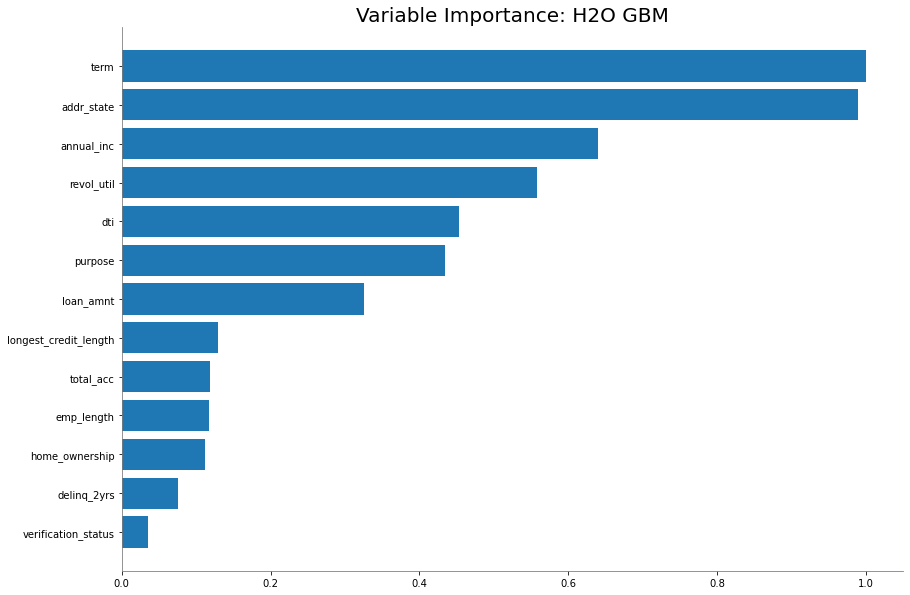

In [18]:
aml.leader.varimp_plot(13)

上位に入るaddr_stateは50水準、purposeは14水準のカテゴリカル変数

In [19]:
print( loans['addr_state'].table().dim[0] )
print( loans['purpose'].table().dim[0] )

50
14


***

<a id='FE'></a>
### 3. Feature Engineeringとそれを利用したモデルの作成

練習として、以下5つのFeature Engineeringをそれぞれの変数に実施する
1. **代数変換(Algebraic Transformation)**
    - 年収(USD)(annual_inc)と与信枠数(total_acc)の比
<br><br>
2. **Target Encoding**
    - 居住数(addr_state)
    - ローン借り入れ理由(purpose)
<br><br>
3. **Combining Categories**
    - 住所形態(home_ownership)
<br><br>
4. **Indicator Functions**
    - 申し込まれたローン期間(月)(term)
    - 所得確認状況(verification_status)
    - 継続雇用期間(年)(emp_length) - 欠損を示すIndicator
<br><br>
5. **Separating Typical from Extreme**
    - 申し込まれたローンの額(USD)(loan_amnt)
    - リボルビングクレジット利用率(%)(revol_util)
    - 過去2年における滞納回数(delinq_2yrs)
    - 年収(USD)(annual_inc)
    - 負債比率(%)(dti)
    - 与信枠数(total_acc)
    - Longest Credit Length(?)

#### 1. 代数変換(Algebraic Transformation)

与信枠数に対する年収を算出`annual_inc/total_acc`  
分布の歪みを整えるため、対数変換も実施

Probs,annual_incQuantiles
0.01,794.19
0.1,1400
0.25,1928.57
0.333,2189.45
0.5,2772.73
0.667,3529.41
0.75,4090.91
0.9,6000
0.99,13562.2


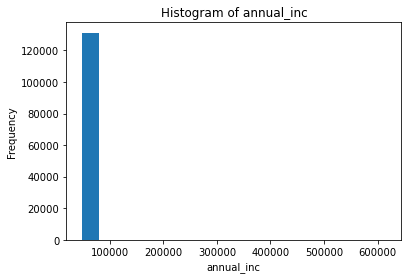

In [20]:
#> 対数変換しない場合
print( (train['annual_inc']/train['total_acc']).quantile() )
(train['annual_inc']/train['total_acc']).hist()

Probs,log(annual_inc)Quantiles
0.01,6.67732
0.1,7.24423
0.25,7.56453
0.333,7.69141
0.5,7.92759
0.667,8.16889
0.75,8.31652
0.9,8.69951
0.99,9.51504


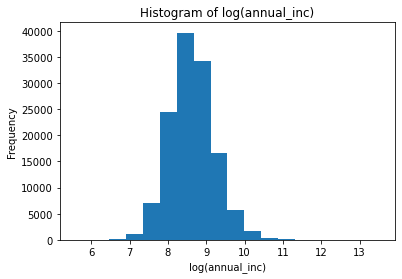

In [21]:
#> 対数変換した場合
print( (train['annual_inc'].log()-train['total_acc'].log()).quantile() )
(train['annual_inc'].log()-train['total_acc'].log()).hist()

In [22]:
transformed = predictors.copy()    # Feature Engineeringを加えた変数のリストtransformedとする

train['log_inc_per_acct'] = train['annual_inc'].log()-train['total_acc'].log()

transformed.append('log_inc_per_acct')
len(transformed)

14

#### 2. Target Encoding

多水準カテゴリカル変数(High-cardinality Categorical Variable)に対し、Cross Varidationを用いた平均値によるTarget Encodingを実施（One-hot Encodingを多水準カテゴリカル変数に実施した場合、オーバーフィッティングが発生する可能性が高いため）  

[参考リソース](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md)

In [23]:
cv_nfolds = 5
cv_seed = 12345
train["cv_fold"] = train.kfold_column(n_folds=cv_nfolds, seed=cv_seed)

train["cv_fold"].table()

cv_fold,Count
0,26201
1,26268
2,26424
3,26020
4,26335


In [24]:
import numpy as np
import pandas as pd

def logit(p):
    return np.log(p) - np.log(1 - p)

def mean_target(data, x, y="bad_loan"):
    """
    xの水準別にyの平均値を算出
    """
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na="ignore").mean(na="ignore")
    return stats.get_frame().as_data_frame()

def mean_target_encoding(data, x, y="bad_loan", fold_column="cv_fold", prior_mean=0.183, prior_count=1):
    """
    Creates target encoding for binary target
    クロスバリデーションTarget Encoding（x*fold_column別にyの集計地を算出）
    
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])   # x*fold_columnでgroup by
    grouped_data.sum(na="ignore").count(na="ignore")   # group by別で、yの合計値を計算（下のsum_yとなる値）
    df = grouped_data.get_frame().as_data_frame()
    #print(df)
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):     # k fold別の処理
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]    # out of foldデータ（x*fold_columnに集約済みデータからkデータを除いたもの）
        #print(oof.shape)
        stats = oof.groupby([x]).sum()    # さらにsum_yの合計を取る
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)   # nrowはgroup by時に作成される
        stats[te_x] = logit(p)
        #stats[te_x] = p
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))
    #return pd.concat(df_list)

- ローン借り入れ理由(purpose)に対しするTarget Encoding

In [25]:
#> ローン借り入れ理由(purpose)に対しての水準数の集計
tbl = train["purpose"].table().as_data_frame()    # 水準数の集計とPandas DFへの変換
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by="Count", ascending=0)
tbl = tbl.reset_index(drop=True)
tbl

,purpose,Count,Percent
0,debt_consolidation,74560,56.81
1,credit_card,24713,18.83
2,other,8416,6.41
3,home_improvement,7940,6.05
4,major_purchase,3750,2.86
5,small_business,3069,2.34
6,car,2280,1.74
7,medical,1626,1.24
8,wedding,1409,1.07
9,moving,1165,0.89


In [26]:
#> purposeの水準別のbad_loanの平均値の確認
df = mean_target(data=train, x="purpose", y="bad_loan")
print(df.shape)
df

(14, 3)


,purpose,nrow,mean_bad_loan
0,car,2280,0.126316
1,credit_card,24713,0.157528
2,debt_consolidation,74560,0.188560
3,educational,312,0.211538
4,home_improvement,7940,0.153149
5,house,990,0.182828
6,major_purchase,3750,0.136000
7,medical,1626,0.197417
8,moving,1165,0.205150
9,other,8416,0.213641


In [27]:
#> purposeに対してクロスバリデーションTarget Encodingの実施
te_purpose = mean_target_encoding(data=train, x="purpose", y="bad_loan", fold_column="cv_fold")
print( te_purpose.shape )
te_purpose

Parse progress: |█████████████████████████████████████████████████████████| 100%
(70, 3)


purpose,cv_fold,te_purpose
car,0,-1.89012
credit_card,0,-1.67871
debt_consolidation,0,-1.45385
educational,0,-1.26173
home_improvement,0,-1.71976
house,0,-1.46434
major_purchase,0,-1.84313
medical,0,-1.37289
moving,0,-1.3466
other,0,-1.2831


In [28]:
#> Target Encode済みのカラムをtrainへマージ
print( train.shape )
train = train.merge(te_purpose, all_x=True)
print( train.shape )

(131248, 17)
(131248, 18)


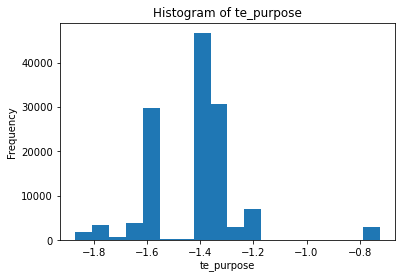

In [29]:
train["te_purpose"].hist()

In [30]:
#> Feature Engineeringを加えた変数のリストtransformedへ、te_purposeを追加し、purposeを削除
transformed.remove("purpose")
transformed.append("te_purpose")
len(transformed)

14

In [31]:
#transformed

- 居住数(addr_state)に対しするTarget Encoding

In [32]:
#> 水準数の集計
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
tbl

,addr_state,Count,Percent
0,CA,22897,17.45
1,NY,11514,8.77
2,TX,9612,7.32
3,FL,9061,6.90
4,NJ,5154,3.93
5,IL,4855,3.70
6,PA,4401,3.35
7,VA,4259,3.25
8,GA,4159,3.17
9,OH,3932,3.00


In [33]:
#> 準別のbad_loanの平均値の確認
df = mean_target(train, "addr_state")
print(df.shape)
df

(50, 3)


,addr_state,nrow,mean_bad_loan
0,AK,334,0.161677
1,AL,1580,0.215190
2,AR,887,0.191657
3,AZ,3152,0.174810
4,CA,22897,0.177840
5,CO,2837,0.141699
6,CT,2051,0.173574
7,DC,460,0.108696
8,DE,344,0.162791
9,FL,9061,0.211566


In [34]:
#> addr_stateに対してクロスバリデーションTarget Encodingの実施
te_addr_state = mean_target_encoding(data=train, x="addr_state", fold_column="cv_fold", prior_mean=0.183, prior_count=30)
print( te_addr_state.shape )
te_addr_state

Parse progress: |█████████████████████████████████████████████████████████| 100%
(250, 3)


addr_state,cv_fold,te_addr_state
AK,0,-1.55264
AL,0,-1.3366
AR,0,-1.36581
AZ,0,-1.5574
CA,0,-1.51659
CO,0,-1.77826
CT,0,-1.6278
DC,0,-2.16897
DE,0,-1.55591
FL,0,-1.31814


In [35]:
#> Target Encode済みのカラムをtrainへマージ
print( train.shape )
train = train.merge(te_addr_state, all_x=True)
print( train.shape )

(131248, 18)
(131248, 19)


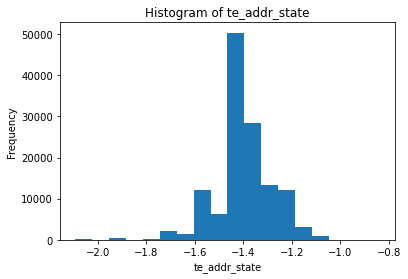

In [36]:
train["te_addr_state"].hist()

In [37]:
#> Feature Engineeringを加えた変数のリストtransformedへ、te_addr_stateを追加し、addr_stateを削除
transformed.remove("addr_state")
transformed.append("te_addr_state")
len(transformed)

14

**現時点でのFeature Engineeringを用いて、精度向上や変化かがあるか確認してみる**

In [38]:
check = H2OAutoML(max_models = 4,
                  max_runtime_secs_per_model = 60,
                  include_algos = ['GBM'],
                  seed = 12345)

%time check.train(x = transformed, y = response, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 4 s, sys: 197 ms, total: 4.2 s
Wall time: 2min 6s


In [39]:
check.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201014_140016,0.681902,0.443227,0.321979,0.369501,0.373279,0.139337
GBM_2_AutoML_20201014_140016,0.680863,0.44363,0.320001,0.370255,0.373492,0.139497
GBM_3_AutoML_20201014_140016,0.679316,0.444302,0.318072,0.369531,0.373802,0.139728
GBM_4_AutoML_20201014_140016,0.673309,0.44684,0.311551,0.375059,0.374991,0.140618


In [40]:
#> leaderboardの一番上のモデル
check.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201014_140016


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,52.0,52.0,41639.0,6.0,6.0,6.0,42.0,64.0,59.423077




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13493321126011548
RMSE: 0.36733256221047905
LogLoss: 0.431001396115889
Mean Per-Class Error: 0.34618653201635197
AUC: 0.7122339488649059
AUCPR: 0.3804843752647407
Gini: 0.42446789772981175

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20564373785375992: 


,,0,1,Error,Rate
0,0,78857.0,28451.0,0.2651,(28451.0/107308.0)
1,1,10395.0,13545.0,0.4342,(10395.0/23940.0)
2,Total,89252.0,41996.0,0.296,(38846.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.205644,0.410853,218.0
1,max f2,0.122957,0.563036,312.0
2,max f0point5,0.300985,0.395887,140.0
3,max accuracy,0.442489,0.823182,64.0
4,max precision,0.858686,1.000000,0.0
5,max recall,0.044814,1.000000,394.0
6,max specificity,0.858686,1.000000,0.0
7,max absolute_mcc,0.238486,0.252847,188.0
8,max min_per_class_accuracy,0.182536,0.653008,242.0
9,max mean_per_class_accuracy,0.185657,0.653813,239.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.490610,3.995911,3.995911,0.728865,0.548460,0.728865,0.548460,0.039975,0.039975,299.591057,299.591057,0.036657
1,2,0.020000,0.446120,2.950118,3.473214,0.538110,0.465859,0.633524,0.507176,0.029490,0.069465,195.011818,247.321357,0.060500
2,3,0.030004,0.417538,2.734923,3.227054,0.498858,0.431556,0.588624,0.481963,0.027360,0.096825,173.492312,222.705426,0.081729
3,4,0.040001,0.395238,2.661792,3.085793,0.485518,0.405967,0.562857,0.462971,0.026608,0.123434,166.179218,208.579258,0.102047
4,5,0.050005,0.377805,2.384185,2.945428,0.434882,0.386530,0.537254,0.447678,0.023851,0.147285,138.418488,194.542828,0.118983
5,6,0.100002,0.316520,2.083669,2.514582,0.380067,0.344108,0.458667,0.395897,0.104177,0.251462,108.366920,151.458157,0.185251
6,7,0.150006,0.277461,1.734177,2.254434,0.316319,0.295585,0.411215,0.362458,0.086717,0.338179,73.417728,125.443359,0.230153
7,8,0.200003,0.250379,1.486306,2.062416,0.271106,0.263197,0.376190,0.337645,0.074311,0.412490,48.630613,106.241636,0.259891
8,9,0.300005,0.211455,1.298226,1.807686,0.236800,0.229651,0.329727,0.301647,0.129825,0.542314,29.822583,80.768618,0.296368
9,10,0.399998,0.182603,1.084861,1.626990,0.197882,0.196455,0.296768,0.275350,0.108480,0.650794,8.486145,62.699033,0.306747




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13933702771441275
RMSE: 0.37327875336591654
LogLoss: 0.44322675203307815
Mean Per-Class Error: 0.36791308937345035
AUC: 0.6819021986431268
AUCPR: 0.3219787107474506
Gini: 0.3638043972862537

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19112222346681107: 


,,0,1,Error,Rate
0,0,72795.0,34513.0,0.3216,(34513.0/107308.0)
1,1,9992.0,13948.0,0.4174,(9992.0/23940.0)
2,Total,82787.0,48461.0,0.3391,(44505.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.191122,0.385299,232.0
1,max f2,0.113216,0.552004,322.0
2,max f0point5,0.281232,0.348509,153.0
3,max accuracy,0.511389,0.818131,36.0
4,max precision,0.821948,1.000000,0.0
5,max recall,0.039243,1.000000,396.0
6,max specificity,0.821948,1.000000,0.0
7,max absolute_mcc,0.208375,0.210850,215.0
8,max min_per_class_accuracy,0.179021,0.631649,244.0
9,max mean_per_class_accuracy,0.174936,0.632087,248.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.490740,2.835134,2.835134,0.517136,0.544654,0.517136,0.544654,0.028363,0.028363,183.513404,183.513404,0.022454
1,2,0.020000,0.446572,2.594934,2.715080,0.473323,0.466720,0.495238,0.505702,0.025940,0.054302,159.493398,171.507976,0.041955
2,3,0.030004,0.417922,2.200465,2.543498,0.401371,0.431366,0.463941,0.480917,0.022013,0.076316,120.046486,154.349790,0.056643
3,4,0.040001,0.396597,2.294072,2.481165,0.418445,0.406825,0.452571,0.462401,0.022932,0.099248,129.407207,148.116520,0.072465
4,5,0.050005,0.379195,2.146184,2.414149,0.391470,0.387570,0.440347,0.447430,0.021470,0.120718,114.618394,141.414853,0.086490
5,6,0.100002,0.317829,1.938297,2.176241,0.353551,0.345594,0.396952,0.396516,0.096909,0.217627,93.829693,117.624086,0.143868
6,7,0.150006,0.278213,1.614723,1.989059,0.294530,0.296974,0.362810,0.363334,0.080744,0.298371,61.472288,98.905869,0.181464
7,8,0.200003,0.250291,1.500509,1.866931,0.273697,0.263417,0.340533,0.338357,0.075021,0.373392,50.050917,86.693062,0.212071
8,9,0.300005,0.211584,1.312845,1.682236,0.239467,0.229550,0.306844,0.302088,0.131287,0.504678,31.284549,68.223557,0.250336
9,10,0.399998,0.182599,1.100318,1.536764,0.200701,0.196491,0.280310,0.275690,0.110025,0.614703,10.031769,53.676442,0.262605




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.65915674,0.026557172,0.6266286,0.6665143,0.68335235,0.63594806,0.6833403
1,auc,0.68195665,0.0031196151,0.68158513,0.68322694,0.6800999,0.67835706,0.68651426
2,aucpr,0.32222983,0.0043676645,0.32161477,0.3237433,0.31539,0.32305548,0.32734567
3,err,0.3408433,0.026557172,0.37337142,0.33348572,0.31664762,0.36405197,0.3166597
4,err_count,8947.0,697.11835,9801.0,8754.0,8312.0,9556.0,8312.0
5,f0point5,0.32162195,0.007576408,0.3120068,0.32761747,0.32524627,0.31498358,0.3282557
6,f1,0.38733143,0.0031157287,0.38624835,0.39182994,0.38319975,0.38790673,0.38747236
7,f2,0.48760223,0.018304272,0.50685334,0.48734966,0.46628383,0.5047676,0.47275668
8,lift_top_group,2.8768778,0.27072653,2.7552335,2.698121,2.6337843,3.2893953,3.0078545
9,logloss,0.44322672,0.0029674899,0.44508258,0.44621855,0.44137272,0.44446033,0.43899947



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-14 14:00:42,26.034 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-14 14:00:43,26.380 sec,5.0,0.379170,0.457988,0.675657,0.328256,3.186655,0.361720
2,,2020-10-14 14:00:43,26.766 sec,10.0,0.375655,0.449833,0.686871,0.341145,3.402996,0.331076
3,,2020-10-14 14:00:43,27.161 sec,15.0,0.373315,0.444519,0.691509,0.347790,3.519909,0.311220
4,,2020-10-14 14:00:44,27.530 sec,20.0,0.371844,0.441138,0.694684,0.352657,3.565839,0.332897
5,,2020-10-14 14:00:44,27.893 sec,25.0,0.370759,0.438680,0.698510,0.358143,3.636821,0.315311
6,,2020-10-14 14:00:45,28.257 sec,30.0,0.369930,0.436763,0.701158,0.362582,3.720331,0.298907
7,,2020-10-14 14:00:45,28.623 sec,35.0,0.369229,0.435210,0.703843,0.367012,3.766261,0.327723
8,,2020-10-14 14:00:45,28.984 sec,40.0,0.368599,0.433788,0.706696,0.371428,3.808015,0.306816
9,,2020-10-14 14:00:46,29.345 sec,45.0,0.368028,0.432513,0.709197,0.375291,3.899875,0.321178



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term,1821.121826,1.000000,0.212047
1,annual_inc,1209.584229,0.664197,0.140841
2,revol_util,1147.597290,0.630160,0.133624
3,dti,932.711060,0.512163,0.108603
4,loan_amnt,679.023926,0.372860,0.079064
5,te_purpose,676.342834,0.371388,0.078752
6,te_addr_state,390.411987,0.214380,0.045459
7,longest_credit_length,319.462799,0.175421,0.037198
8,total_acc,308.268066,0.169274,0.035894
9,emp_length,291.382050,0.160001,0.033928


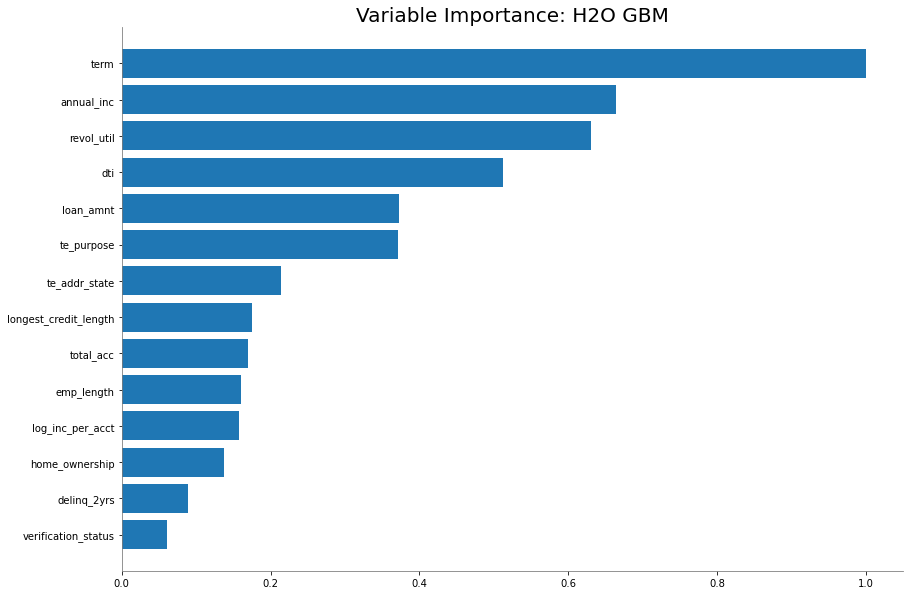

In [41]:
#> 変数重要度
check.leader.varimp_plot(14)

- log_inc_per_acctは11番目
- Target Encodingにより、addr_stateの重要度が低下した（Base Modelではオーバーフィッティング気味）

In [42]:
#> テストデータに対する結果の取得
perf2 = check.leader.model_performance(test_data=test)

In [43]:
print("--- AUC of Base Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))
print("--- AUC of 中間 Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(check.leader.auc(train=True),
                                                                  check.leader.auc(xval=True), 
                                                                  perf2.auc()))

--- AUC of Base Model ---
AUC: train = 0.7258, X-val = 0.6812, test = 0.6835
--- AUC of 中間 Model ---
AUC: train = 0.7122, X-val = 0.6819, test = 0.6749


精度向上が見込めなかったのは、H2OGradientBoostingEstimatorにおいて多水準カテゴリカル変数(High-cardinality Categorical Variable)の自動処理が組み込まれているためと推測できる  
H2OGradientBoostingEstimatorの[categorical_encoding引数に関して](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/categorical_encoding.html)

#### 3. Combining Categories

住所形態(home_ownership)は6水準のカテゴリカル変数だが、バランスの悪い構成となっている  
数の少ないANY,NONE,OTHERとRENTと結合して、OTHERカテゴリとする

In [44]:
#> home_ownership別での、bad_loanの平均割合
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,63757,0.163496
2,NONE,27,0.259259
3,OTHER,116,0.250000
4,OWN,10903,0.186004
5,RENT,56444,0.202891


In [45]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()
train[["home_ownership", "home_ownership_3cat"]].table()

transformed.remove("home_ownership")
transformed.append("home_ownership_3cat")
print( len(transformed) )

mean_target(train, "home_ownership_3cat")

14


,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,63757,0.163496
1,OTHER,56588,0.203011
2,OWN,10903,0.186004


#### 4. Indicator Functions

- ローン期間(term)を5年を示す場合に1、3年を0に変換

In [46]:
train["term"].table()

term,Count
36 months,104026
60 months,27222


In [48]:
#> 60 months->1, 36 months -> 0 へ変換
train["term_60months"] = (train["term"] == "60 months")
train["term_60months"].table()

term_60months,Count
0,104026
1,27222


In [49]:
#> 変数名の置き換え
transformed.remove("term")
transformed.append("term_60months")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months']

- 所得確認状況(verification_status)をverifiedの場合1に、not varifiedの場合に0に変換

In [50]:
train["verification_status"].table()

verification_status,Count
not verified,47286
verified,83962


In [51]:
train["verified"] = (train["verification_status"] == "verified")
train["verified"].table()

verified,Count
0,47286
1,83962


In [52]:
transformed.remove("verification_status")
transformed.append("verified")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified']

- 継続雇用期間(年)(emp_length)が欠損を示す新しい変数（欠損だと1）を作成

In [53]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.680845012561438
maxs,10.0
sigma,3.608577939766145
zeros,11391
missing,4670
0,nan
1,10.0
2,1.0


In [60]:
#> 欠損の割合
train["emp_length"].isna().sum() / train.nrows

0.03558149457515543

In [64]:
#> emp_lengthが欠損(nan)だと1となる変数(emp_length_missing)を作成
train["emp_length_missing"] = (train["emp_length"] == None)
train["emp_length_missing"].table()

emp_length_missing,Count
0,126578
1,4670


In [67]:
#> 変数名の追加
transformed.append("emp_length_missing")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing']

In [68]:
#> emp_lengthの水準別にbad_loanの割合を確認してみる
df = mean_target(train, "emp_length")
df.drop(df.index[:1], inplace=True)   # remove NaN
df

,emp_length,nrow,mean_bad_loan
1,0.0,11391,0.183127
2,1.0,9056,0.178666
3,2.0,12712,0.171413
4,3.0,10930,0.178957
5,4.0,8825,0.171671
6,5.0,9910,0.180424
7,6.0,8035,0.186808
8,7.0,7259,0.190384
9,8.0,5901,0.182342
10,9.0,4871,0.185178


In [71]:
#> emp_length_missingの水準別にbad_loanの割合を確認してみる
mean_target(train, "emp_length_missing")

,emp_length_missing,nrow,mean_bad_loan
0,0,126578,0.179494
1,1,4670,0.261242


欠損か否かで大きくbad_loanの割合が異なっている

#### 5. Separating Typical from Extreme

数値変数のカテゴリカル変数化

    - 申し込まれたローンの額(USD)(loan_amnt)
    - リボルビングクレジット利用率(%)(revol_util)
    - 過去2年における滞納回数(delinq_2yrs)
    - 年収(USD)(annual_inc)
    - 負債比率(%)(dti)
    - 与信枠数(total_acc)
    - Longest Credit Length(?)

- ローン額(loan_amnt)に対し、変数変換を実施

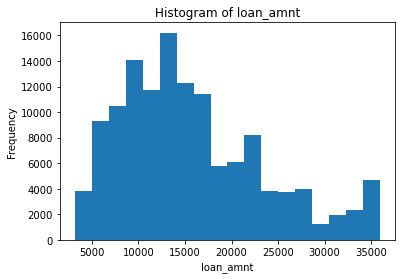

In [72]:
train["loan_amnt"].hist()

In [73]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [76]:
#> 0から35000の間を等間隔に分け、8つの閾値を作成（7つの区間）
breaks = np.linspace(0, 35000, 8).tolist()
breaks

[0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0]

In [77]:
#> loan_amountを7つの区間に分けたカテゴリ変数（loan_amnt_cat）を作成
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)
train[["loan_amnt_cat","loan_amnt"]]

loan_amnt_cat,loan_amnt
"(0.0,5000.0]",3500
"(5000.0,10000.0]",7500
"(10000.0,15000.0]",15000
"(15000.0,20000.0]",20000
"(5000.0,10000.0]",6950
"(30000.0,35000.0]",35000
"(5000.0,10000.0]",10000
"(10000.0,15000.0]",10400
"(15000.0,20000.0]",20000
"(10000.0,15000.0]",13000


In [78]:
mean_target(train, "loan_amnt_cat")

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",20634,0.164050
1,"(5000.0,10000.0]",40364,0.162397
2,"(10000.0,15000.0]",28359,0.172785
3,"(15000.0,20000.0]",19727,0.208800
4,"(20000.0,25000.0]",11572,0.212323
5,"(25000.0,30000.0]",5565,0.240611
6,"(30000.0,35000.0]",5027,0.235727


loan_amntが5000から30000までbad_loanが増えていっており、5000より下と、30000より上はフラットになっている

In [82]:
#> 5000より下と、30000より上のloan_amntはそれぞれ5000と30000に置き換える新しい変数（loan_amnt_core）を作成
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)
train[["loan_amnt","loan_amnt_core"]]

loan_amnt,loan_amnt_core
3500,5000
7500,7500
15000,15000
20000,20000
6950,6950
35000,30000
10000,10000
10400,10400
20000,20000
13000,13000


In [84]:
#> 置き換えを示す情報を持つ変数（loan_amnt_diff）を作成しておく
train["loan_amnt_diff"] = train["loan_amnt"] - train["loan_amnt_core"]
train[["loan_amnt","loan_amnt_core","loan_amnt_diff"]]

loan_amnt,loan_amnt_core,loan_amnt_diff
3500,5000,-1500
7500,7500,0
15000,15000,0
20000,20000,0
6950,6950,0
35000,30000,5000
10000,10000,0
10400,10400,0
20000,20000,0
13000,13000,0


In [83]:
#> 変数名の削除と追加
transformed.remove("loan_amnt")
transformed.append("loan_amnt_core")
transformed.append("loan_amnt_diff")
transformed

['emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff']

- リボルビングクレジット利用率(revol_util)に対する変数変換の実施

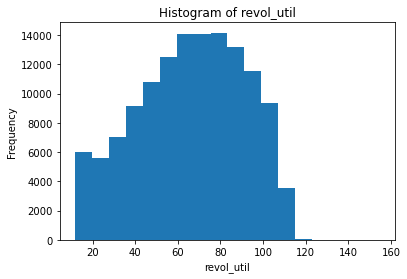

In [85]:
train["revol_util"].hist()